In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import zipfile

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

In [61]:
cfg = dict(
    crs = 'EPSG:5514',
    figsize = (12,12),
    data_dir = os.path.join('..', 'data'),
    data = 'Sverepec_spolu_so_sur.zip',
    class_column = 'DRUH_DR',
    common_class_name = 'OTHER',
    lon_column='POINT_X',
    lat_column='POINT_Y',
    random_state=0
)
display(JSON(cfg))

<IPython.core.display.JSON object>

In [375]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def nsplit_df(df:pd.DataFrame, splits:[float]=[0.7]) -> pd.DataFrame:
    rows = df.shape[0]
    df_splits = []
    beg = 0
    for split in splits:
        at = int(split * rows)
        df_splits.append(df[beg:at])
        beg = at
    df_splits.append(df[beg:])
    return df_splits

def predict_model(m, X, label_encoder):
    Y = m.predict(X)
    Y = np.argmax(Y, axis=1)
    Y = label_encoder.inverse_transform(Y)
    Y = pd.DataFrame(Y, columns=['Y_pred'])
    return Y

def plot_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

# Preprocess data

## Load

In [85]:
filename = os.path.join(cfg['data_dir'], cfg['data'])
df = pd.read_csv(filename)

class_mapping = {
    'ÄŤremcha': 'TP'
}

df = df.replace({cfg['class_column']: class_mapping})


display(HTML('<h2>Data preview:</h2>'))
display(df)
display(HTML('<hr>'))
display(HTML('<h2>Data statistics:</h2>'))
display(df.describe())

X            Y  b1_12_10_2  b2_12_10_2  b3_12_10_2  \
0     -467432.576 -1185578.788    0.002312    0.002194    0.002344   
1     -467432.366 -1185578.788    0.002277    0.002337    0.002361   
2     -467432.156 -1185578.788    0.002243    0.002479    0.002402   
3     -467431.946 -1185578.788    0.001883    0.002045    0.002057   
4     -467431.736 -1185578.788    0.002193    0.001915    0.002164   
...           ...          ...         ...         ...         ...   
33715 -467354.036 -1185783.538    0.002469    0.002863    0.003135   
33716 -467353.826 -1185783.538    0.001235    0.000966    0.000953   
33717 -467353.616 -1185783.538    0.001709    0.001565    0.001225   
33718 -467353.406 -1185783.538    0.001823    0.001716    0.001534   
33719 -467353.196 -1185783.538    0.001937    0.001867    0.001843   

       b4_12_10_2  b5_12_10_2  b6_12_10_2  b7_12_10_2  b8_12_10_2  ...  \
0        0.002613    0.002497    0.002717    0.002706    0.002898  ...   
1        0.002488    0.002334    0.002713    0.002796    0.002779  ...   
2        0.002322    0.002627    0.002943    0.002809    0.002854  ...   
3        0.001970    0.002191    0.002052    0.002102    0.001991  ...   
4        0.002090    0.002031    0.002108    0.002084    0.002123  ...   
...           ...         ...         ...         ...         ...  ...   
33715    0.003027    0.003056    0.003230    0.003328    0.003523  ...   
33716    0.001050    0.000891    0.001143    0.000930    0.001075  ...   
33717    0.001534    0.001722    0.002060    0.001738    0.001615  ...   
33718    0.001772    0.001997    0.002358    0.002048    0.001988  ...   
33719    0.002009    0.002272    0.002657    0.002358    0.002361  ...   

       b180_12_10  b181_12_10  b182_12_10  b183_12_10  b184_12_10  b185_12_10  \
0        0.043107    0.045929    0.051554    0.052172    0.054623    0.054570   
1        0.039885    0.043333    0.047781    0.048725    0.047153    0.050167   
2        0.042160    0.042548    0.048506    0.049747    0.050620    0.051325   
3        0.033034    0.034035    0.037514    0.040421    0.040852    0.040839   
4        0.024879    0.026462    0.029662    0.030414    0.031456    0.031279   
...           ...         ...         ...         ...         ...         ...   
33715    0.026700    0.027315    0.031556    0.033276    0.032708    0.033844   
33716    0.006300    0.007368    0.007559    0.008111    0.009299    0.008149   
33717    0.025439    0.025496    0.027390    0.029442    0.033317    0.032171   
33718    0.027549    0.027910    0.030475    0.032133    0.035963    0.035193   
33719    0.029659    0.030325    0.033560    0.034823    0.038610    0.038214   

       b186_12_10  DRUH_DR     POINT_X      POINT_Y  
0        0.054656       CR -467432.576 -1185578.788  
1        0.052182       CR -467432.366 -1185578.788  
2        0.054525       CR -467432.156 -1185578.788  
3        0.042109       CR -467431.946 -1185578.788  
4        0.032800       CR -467431.736 -1185578.788  
...           ...      ...         ...          ...  
33715    0.033287       BR -467354.036 -1185783.538  
33716    0.008633       BR -467353.826 -1185783.538  
33717    0.032443       BR -467353.616 -1185783.538  
33718    0.035305       BR -467353.406 -1185783.538  
33719    0.038167       BR -467353.196 -1185783.538  

[33720 rows x 191 columns]

X             Y    b1_12_10_2    b2_12_10_2    b3_12_10_2  \
count   33720.000000  3.372000e+04  33720.000000  33720.000000  33720.000000   
mean  -467375.005640 -1.185670e+06      0.002247      0.002304      0.002430   
std        35.949793  6.093222e+01      0.000882      0.000927      0.000999   
min   -467452.946000 -1.185784e+06      0.000369      0.000332      0.000345   
25%   -467402.546000 -1.185709e+06      0.001588      0.001611      0.001675   
50%   -467371.046000 -1.185652e+06      0.002207      0.002261      0.002381   
75%   -467357.606000 -1.185621e+06      0.002824      0.002898      0.003079   
max   -467298.386000 -1.185579e+06      0.005978      0.006260      0.006729   

         b4_12_10_2    b5_12_10_2    b6_12_10_2    b7_12_10_2    b8_12_10_2  \
count  33720.000000  33720.000000  33720.000000  33720.000000  33720.000000   
mean       0.002565      0.002615      0.002691      0.002687      0.002638   
std        0.001066      0.001103      0.001149      0.001161      0.001158   
min        0.000441      0.000444      0.000410      0.000456      0.000441   
25%        0.001761      0.001775      0.001806      0.001789      0.001735   
50%        0.002520      0.002568      0.002650      0.002657      0.002603   
75%        0.003261      0.003335      0.003446      0.003457      0.003407   
max        0.007038      0.007524      0.007449      0.007360      0.007368   

       ...    b179_12_10    b180_12_10    b181_12_10    b182_12_10  \
count  ...  33720.000000  33720.000000  33720.000000  33720.000000   
mean   ...      0.028207      0.027531      0.029403      0.031902   
std    ...      0.017572      0.017085      0.018232      0.019761   
min    ...      0.000697      0.000635      0.000652      0.000638   
25%    ...      0.013299      0.013060      0.013952      0.015179   
50%    ...      0.026038      0.025482      0.027207      0.029539   
75%    ...      0.042118      0.041040      0.043859      0.047575   
max    ...      0.078523      0.076033      0.080653      0.085611   

         b183_12_10    b184_12_10    b185_12_10    b186_12_10        POINT_X  \
count  33720.000000  33720.000000  33720.000000  33720.000000   33720.000000   
mean       0.033641      0.034560      0.035118      0.035639 -467375.005640   
std        0.020832      0.021402      0.021732      0.022028      35.949793   
min        0.000869      0.000687      0.001013      0.000771 -467452.946000   
25%        0.016041      0.016421      0.016770      0.016946 -467402.546000   
50%        0.031093      0.031970      0.032546      0.033004 -467371.046000   
75%        0.050114      0.051479      0.052331      0.053096 -467357.606000   
max        0.091917      0.093709      0.094180      0.095604 -467298.386000   

            POINT_Y  
count  3.372000e+04  
mean  -1.185670e+06  
std    6.093222e+01  
min   -1.185784e+06  
25%   -1.185709e+06  
50%   -1.185652e+06  
75%   -1.185621e+06  
max   -1.185579e+06  

[8 rows x 190 columns]

## Make geodataframe

In [86]:
# to geodataframe
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df[cfg['lon_column']], df[cfg['lat_column']])
)
gdf.crs = 'EPSG:5514'
gdf = gdf.drop(['X','POINT_X', 'Y', 'POINT_Y'], axis=1)
df = gdf

## Load GIS data

In [53]:
gdf_sk_obce = gpd.read_file(os.path.join('..', 'maps', 'ah_shp_0.zip'), layer='obec_0')
gdf_sk_obce = gdf_sk_obce.to_crs(cfg['crs'])

## Visualize location of measured data

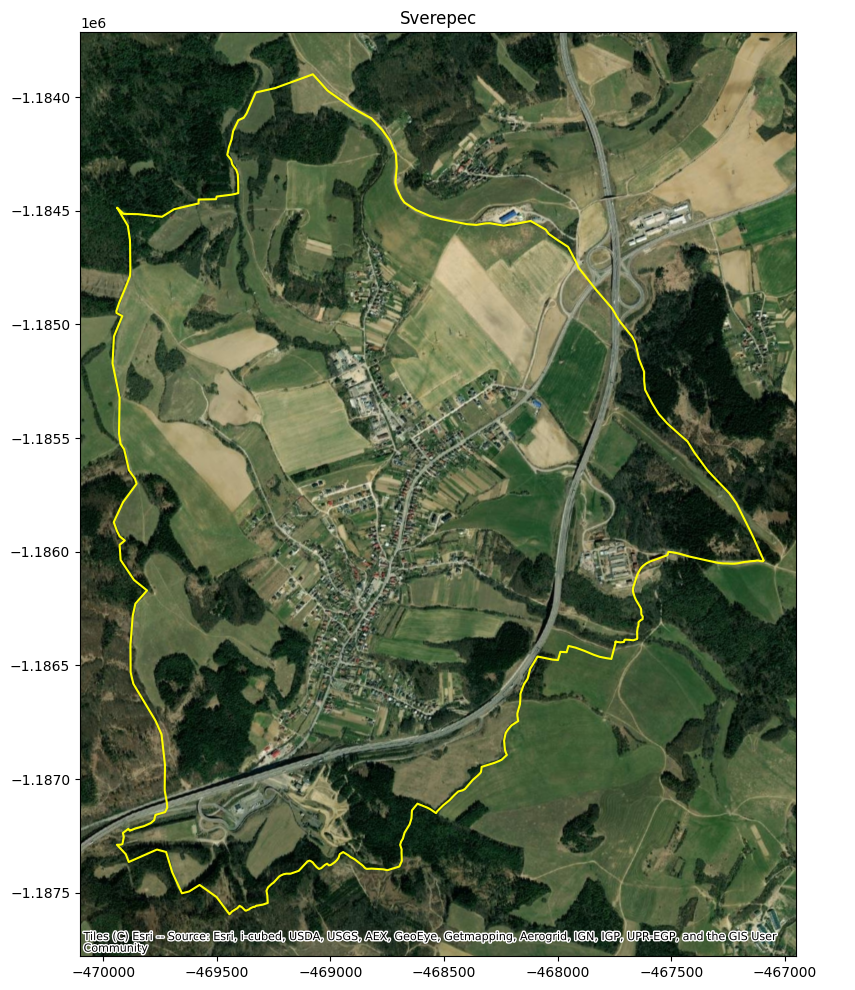

In [54]:
gdf_sverepec = gdf_sk_obce[gdf_sk_obce.NM4 == 'Sverepec']
ax = gdf_sverepec.boundary.plot(figsize=cfg['figsize'], color=to_rgba('yellow', 1.0))
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=cfg['crs'])
plt.title(gdf_sverepec.NM4.values[0])
plt.show()

In [57]:
# select data to plot (sample to speed up)
frac=0.33
gdf_plot = gdf[['geometry','DRUH_DR']].sample(
    frac=frac,
    random_state=cfg['random_state']
)

# zoom out
scale = 0.1
bbox = gdf_plot.total_bounds
dx = scale * np.abs(bbox[2]-bbox[0])
dy = scale * np.abs(bbox[3]-bbox[1])

# plot
f, ax = plt.subplots(1, figsize=cfg['figsize'])

# set boundaries
ax.set_xlim(bbox[0]-dx, bbox[2]+dx)
ax.set_ylim(bbox[1]-dy, bbox[3]+dy)

gdf_plot.plot(
    ax=ax,
    column='DRUH_DR',
    legend=True,
    alpha=0.75,
    marker=',',
    markersize=1
)

# basemap - satelite imagery
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=cfg['crs'])

plt.title('Data preview with satelite imagery background\n%.0f%% pixel sampling' % (100.0 * frac))
plt.show()

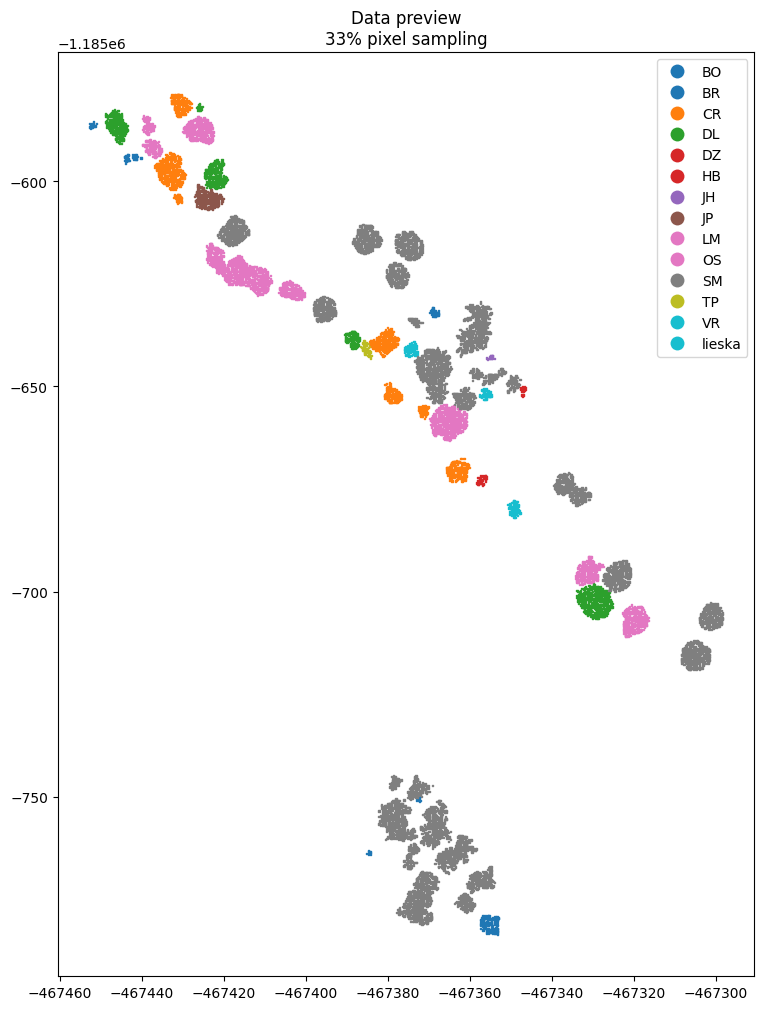

In [87]:
frac=0.33
gdf.sample(
    frac=frac,
    random_state=cfg['random_state']
).plot(
    column=cfg['class_column'],
    legend=True,
    figsize=cfg['figsize'],
    marker=',',
    markersize=1
)
plt.title('Data preview\n%.0f%% pixel sampling' % (100.0 * frac))
plt.show()

## Data rasterization

In [178]:
# class column must be of categorical type
class_column_enums = np.unique(gdf[cfg['class_column']].values)
class_column_enums = np.concatenate((class_column_enums, [cfg['common_class_name']]))
class_column_dtype = pd.api.types.CategoricalDtype(class_column_enums)

display(class_column_dtype)

gdf[cfg['class_column']] = gdf[cfg['class_column']].astype(class_column_dtype)

CategoricalDtype(categories=['BO', 'BR', 'CR', 'DL', 'DZ', 'HB', 'JH', 'JP', 'LM', 'OS',
                  'SM', 'TP', 'VR', 'lieska', 'OTHER'],
, ordered=False)

In [249]:
def rasterize(gdf: gpd.GeoDataFrame, class_column_enums, resolution=(-1, 1), method=None):
    return make_geocube(
        vector_data=gdf,
        resolution=resolution,
        interpolate_na_method=None,
        rasterize_function=partial(
            geocube.rasterize.rasterize_image, # https://corteva.github.io/geocube/stable/geocube.html#geocube.rasterize.rasterize_image
            all_touched=True,
            filter_nan=True
        ),
        categorical_enums={cfg['class_column']: class_column_enums}
    )

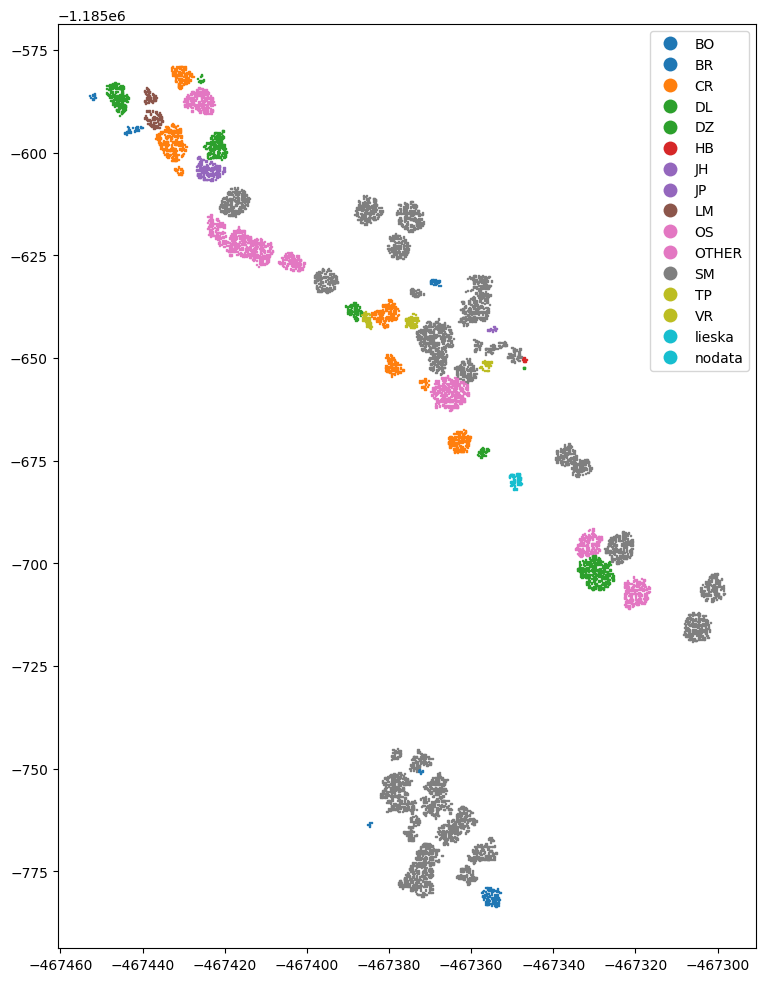

In [284]:
gdf_sample = gdf.sample(frac=0.2)

gdf_sample.plot(column=cfg['class_column'], legend=True, figsize=cfg['figsize'], marker=',', markersize=1)
plt.show()

In [250]:
geo_grid = rasterize(
    gdf_sample,
    class_column_enums,
    resolution=(-2,2),
    method='cubic'
)
geo_grid.get(cfg['class_column']).plot()
plt.show()

In [252]:
def plot_wavelengths2(df, title=None, filename=None, fileformat='pdf', class_column='DRUH_DR',**args):
    df = df.melt(id_vars=class_column)
    df = df.rename(columns={'variable': 'band', 'value': 'reflectance'})
    g = sns.lineplot(df, x='band', y='reflectance', hue=class_column, dashes=False, lw=1, **args)
    g.set(xticklabels=[])
    if title is not None:
        plt.title(title)
    if filename is not None:
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()

In [271]:
geo_grid2 = geo_grid.copy(deep=True)
geo_grid2['DRUH_DR'] = geo_grid2['DRUH_DR_categories'][geo_grid2['DRUH_DR'].astype(int)].drop('DRUH_DR_categories')

df2 = geo_grid2.drop('DRUH_DR_categories').to_dataframe()
df2 = df2.reset_index().drop(['spatial_ref'], axis=1)
df2 = df2[~df2['DRUH_DR'].str.match('nodata')]
df2

y         x  b1_12_10_2  b2_12_10_2  b3_12_10_2  b4_12_10_2  \
10   -1185579.0 -467433.0    0.001847    0.002007    0.002162    0.002195   
11   -1185579.0 -467431.0    0.001949    0.001879    0.002013    0.002204   
12   -1185579.0 -467429.0    0.001544    0.001431    0.001494    0.001725   
88   -1185581.0 -467433.0    0.002851    0.002745    0.002896    0.003161   
89   -1185581.0 -467431.0    0.002290    0.002516    0.002674    0.002456   
...         ...       ...         ...         ...         ...         ...   
7927 -1185781.0 -467355.0    0.002723    0.002893    0.002822    0.002967   
7928 -1185781.0 -467353.0    0.000862    0.000629    0.000964    0.000695   
8004 -1185783.0 -467357.0    0.000788    0.000776    0.000719    0.000867   
8005 -1185783.0 -467355.0    0.001481    0.001437    0.001535    0.001382   
8006 -1185783.0 -467353.0    0.002312    0.002220    0.002517    0.002562   

      b5_12_10_2  b6_12_10_2  b7_12_10_2  b8_12_10_2  ...  b178_12_10  \
10      0.002253    0.002232    0.002634    0.002500  ...    0.042591   
11      0.002157    0.002409    0.002313    0.002258  ...    0.035174   
12      0.001492    0.001812    0.001595    0.001610  ...    0.018203   
88      0.003389    0.003450    0.003662    0.003707  ...    0.061433   
89      0.002868    0.003081    0.003208    0.003266  ...    0.045271   
...          ...         ...         ...         ...  ...         ...   
7927    0.003346    0.003391    0.003157    0.003433  ...    0.046932   
7928    0.000751    0.000867    0.000800    0.000814  ...    0.002108   
8004    0.001059    0.000764    0.000771    0.000856  ...    0.004869   
8005    0.001506    0.001850    0.001716    0.001602  ...    0.015741   
8006    0.002583    0.002815    0.002612    0.002911  ...    0.027704   

      b179_12_10  b180_12_10  b181_12_10  b182_12_10  b183_12_10  b184_12_10  \
10      0.040995    0.041098    0.044175    0.048496    0.045442    0.047446   
11      0.033749    0.034133    0.035876    0.037512    0.040747    0.041871   
12      0.018330    0.017689    0.018831    0.020150    0.020705    0.022859   
88      0.056105    0.057110    0.059625    0.064433    0.068513    0.067585   
89      0.042943    0.041671    0.044989    0.048759    0.051409    0.052728   
...          ...         ...         ...         ...         ...         ...   
7927    0.043935    0.041908    0.046050    0.050060    0.050296    0.055461   
7928    0.001785    0.001803    0.002013    0.002040    0.002194    0.002370   
8004    0.004525    0.003486    0.005022    0.004760    0.005687    0.005348   
8005    0.016740    0.015194    0.014871    0.016311    0.016985    0.017322   
8006    0.025701    0.026945    0.028725    0.029343    0.031391    0.033292   

      b185_12_10  b186_12_10  DRUH_DR  
10      0.049820    0.051399       CR  
11      0.043255    0.043647       CR  
12      0.022474    0.022374       CR  
88      0.070269    0.073418       CR  
89      0.053790    0.053606       CR  
...          ...         ...      ...  
7927    0.053750    0.055681       BR  
7928    0.002463    0.002612       BR  
8004    0.005430    0.005833       BR  
8005    0.019492    0.018891       BR  
8006    0.032772    0.034448       BR  

[661 rows x 189 columns]

In [264]:
plot_wavelengths2(df2)

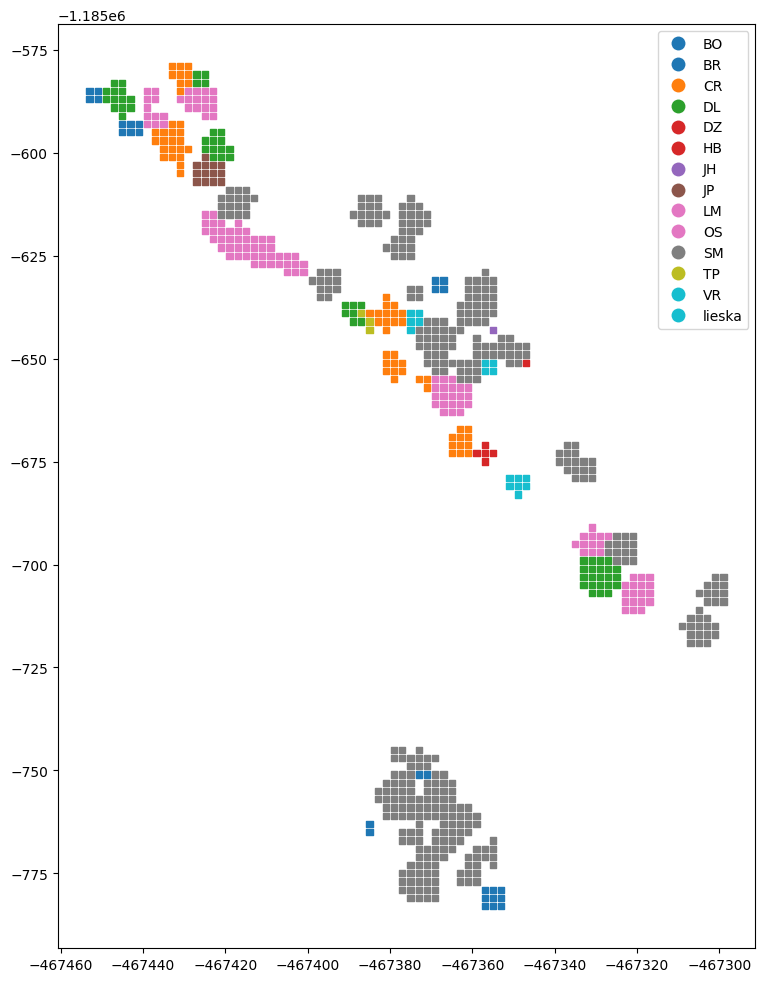

In [283]:
gdf2 = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df2.x, df2.y)
)
gdf2 = gdf2.drop(columns=[df2.x.name, df2.y.name])
gdf2.crs = cfg['crs']


gdf2.plot(
    column=cfg['class_column'],
    legend=True,
    figsize=cfg['figsize'],
    marker=',',
    markersize=20
)

plt.show()

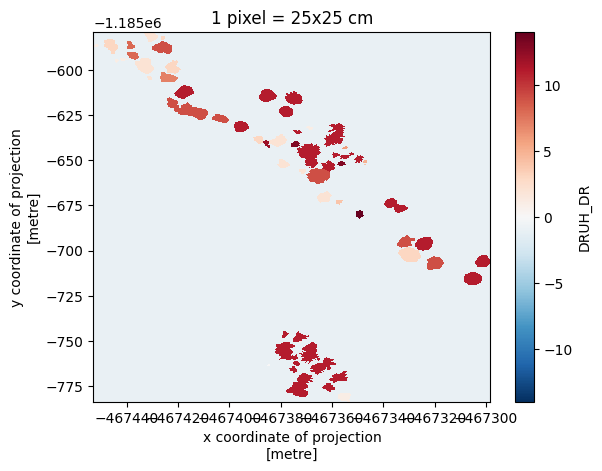

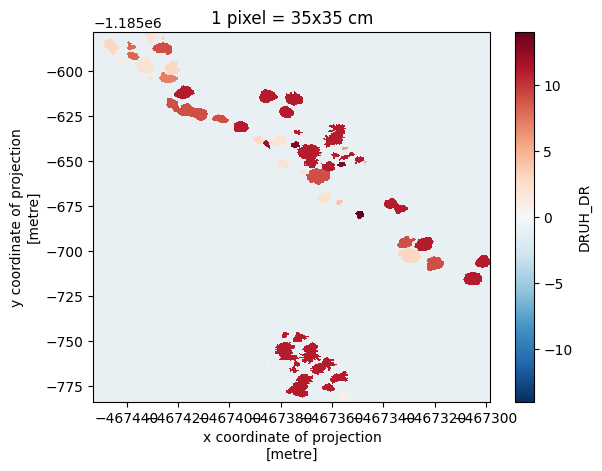

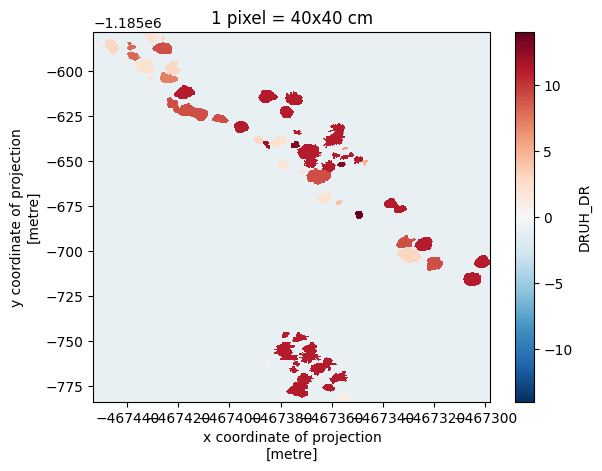

In [292]:
resolutions = {
    '20x20 cm': (-0.2, 0.2),
    '25x25 cm': (-0.25, 0.25),
    '30x30 cm': (-0.3, 0.3),
    '35x35 cm': (-0.35, 0.35),
    '40x40 cm': (-0.4, 0.4),
    '45x45 cm': (-0.45, 0.45),
    '50x50 cm': (-0.5, 0.5),
    '1x1 m': (-1,1),
}

# gdf_sample = gdf.sample(frac=0.05)

rasters = {}
for name, resolution in resolutions.items():
    method = 'nearest'
    geo_grid = rasterize(
        gdf,
        class_column_enums,
        resolution=resolution,
        method=method
    )
    rasters[name] = geo_grid
    geo_grid.get(cfg['class_column']).plot()
    plt.title('1 pixel = %s' % name)
    plt.show()

In [295]:
def geo_grid_to_gdf(geo_grid):
    geo_grid = geo_grid.copy(deep=True)
    geo_grid[cfg['class_column']] = geo_grid['%s_categories' % cfg['class_column']][geo_grid[cfg['class_column']].astype(int)].drop('%s_categories' % cfg['class_column'])
    df = geo_grid.drop('DRUH_DR_categories').to_dataframe()
    df = df.reset_index().drop(['spatial_ref'], axis=1)
    df = df[~df[cfg['class_column']].str.match('nodata')]
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.x, df.y)
    )
    gdf = gdf.drop(columns=[df.x.name, df.y.name])
    gdf.crs = cfg['crs']
    return gdf

In [299]:
gdf_1x1 = geo_grid_to_gdf(rasters['1x1 m'])

gdf_1x1.plot(
    column=cfg['class_column'],
    legend=True,
    figsize=cfg['figsize'],
    marker=',',
    markersize=1
)
plt.show()

## Minimum distance between two different pixels

In [332]:
def pairwise_min_diff(a: np.array):
    a = np.abs(a[:, None] - a)
    return a[a > 0].min()

xmin = pairwise_min_diff(gdf.geometry.x.unique())
ymin = pairwise_min_diff(gdf.geometry.y.unique())
print(f'xmin: {xmin}')
print(f'ymin: {ymin}')

xmin: 0.2099999999627471
ymin: 0.2099999999627471


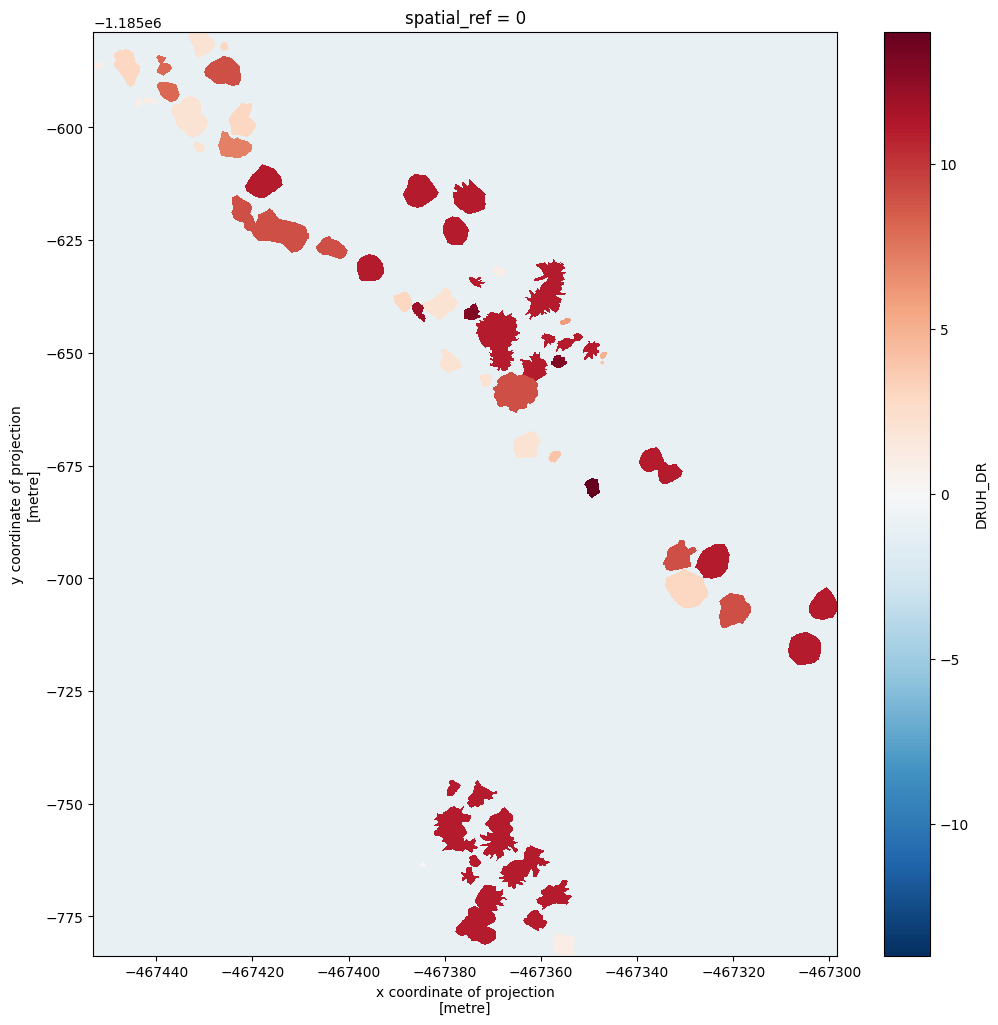

In [334]:
geo_grid = rasterize(
    gdf,
    class_column_enums,
    resolution=(-xmin,ymin),
    method='cubic'
)
geo_grid.get(cfg['class_column']).plot(figsize=cfg['figsize'])
plt.show()

In [335]:
geo_grid = rasterize(
    gdf,
    class_column_enums,
    resolution=(-xmin*10,ymin*10),
    method='cubic'
)
geo_grid.get(cfg['class_column']).plot(figsize=cfg['figsize'])
plt.show()

## Predict on unseen rasterized downscaled data

wandb: Downloading large artifact run_rdtfm1l1_model:v14, 71.23MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Bat  (None, 186, 1)           4         
 chNormalization)                                                
                                                                 
 conv1d_12 (Conv1D)          (None, 186, 1024)         10240     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 1024)         0         
 )                                                               
                                                                 
 conv1d_13 (Conv1D)          (None, 93, 512)           4719104   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 512)          0         
 1D)                                                             
                                                      

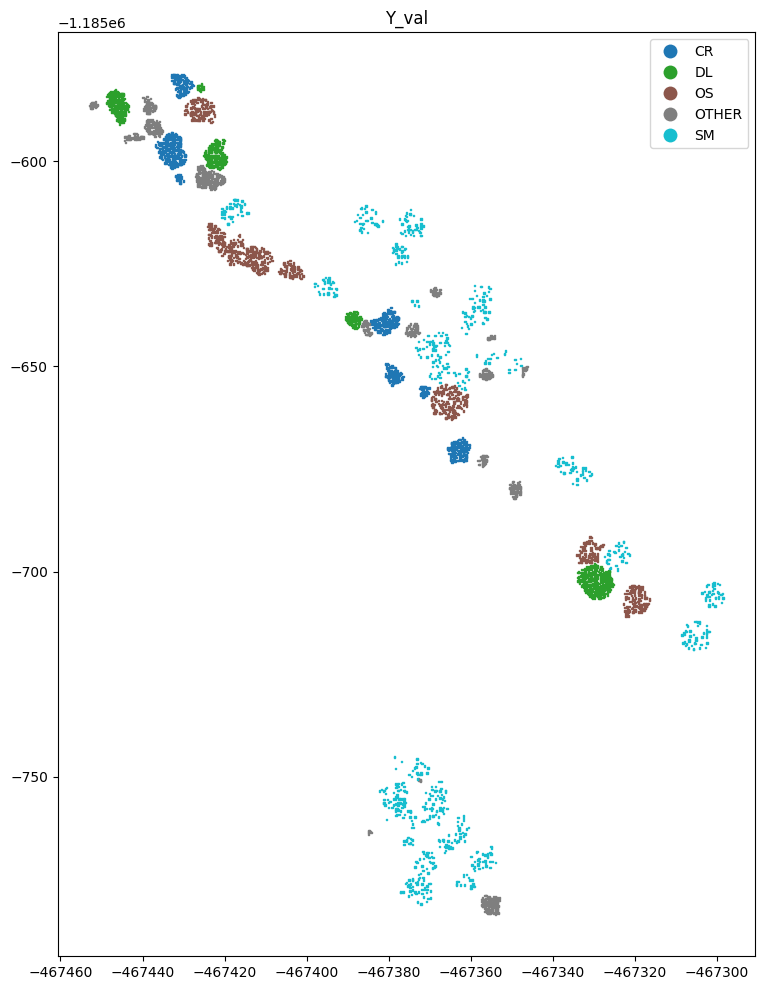

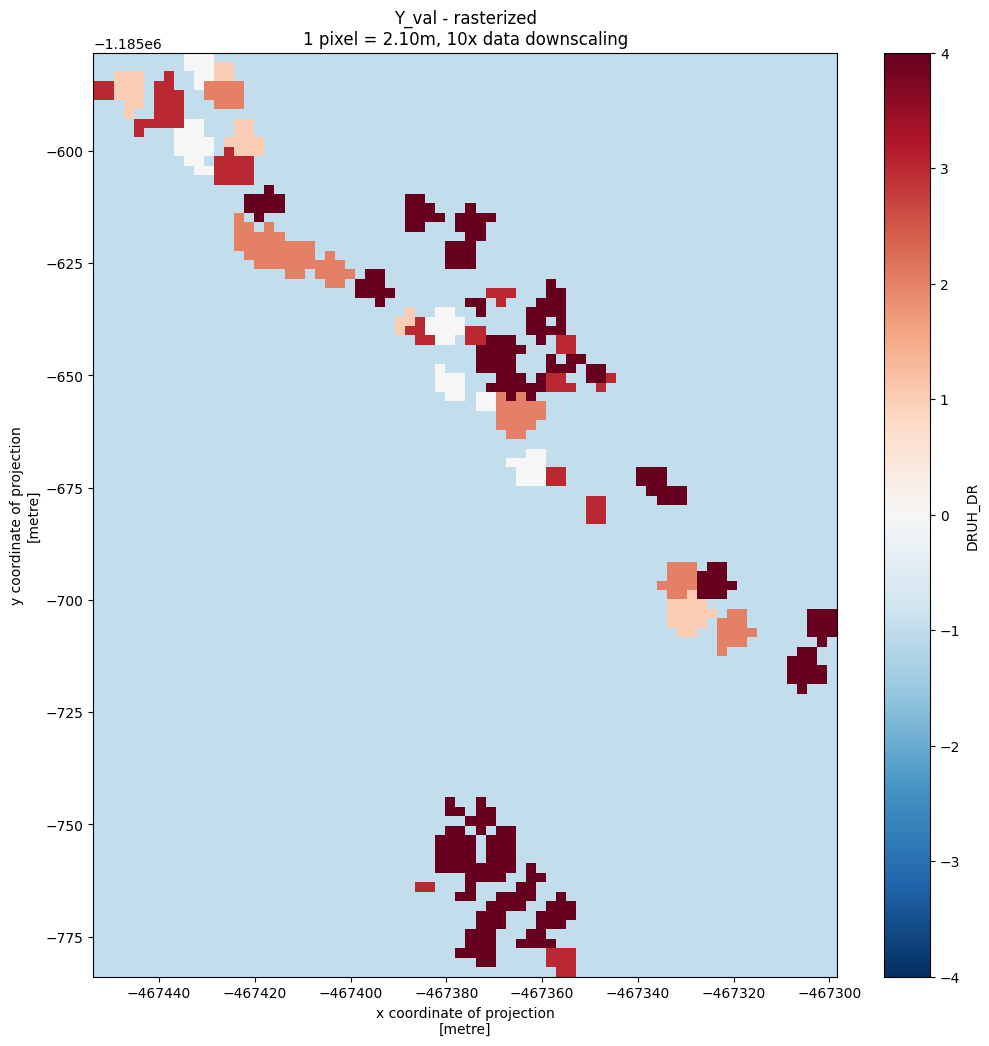

17/17 [==============================] - 0s 9ms/step - loss: 0.2178 - categorical_accuracy: 0.9298


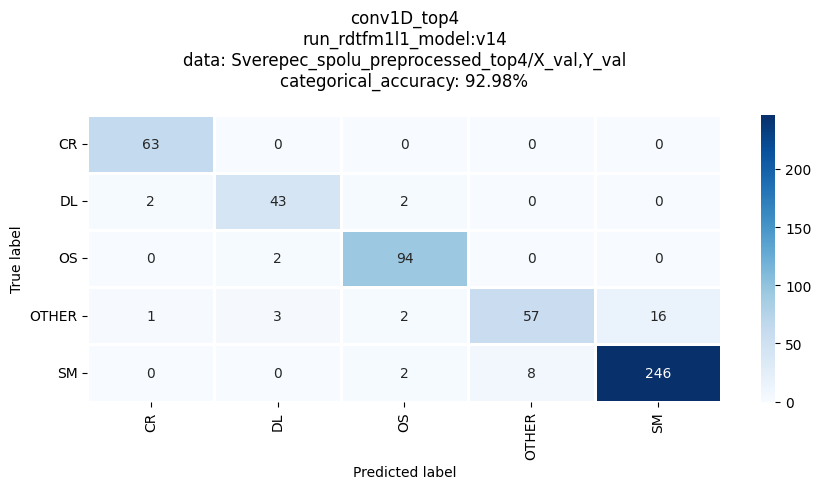

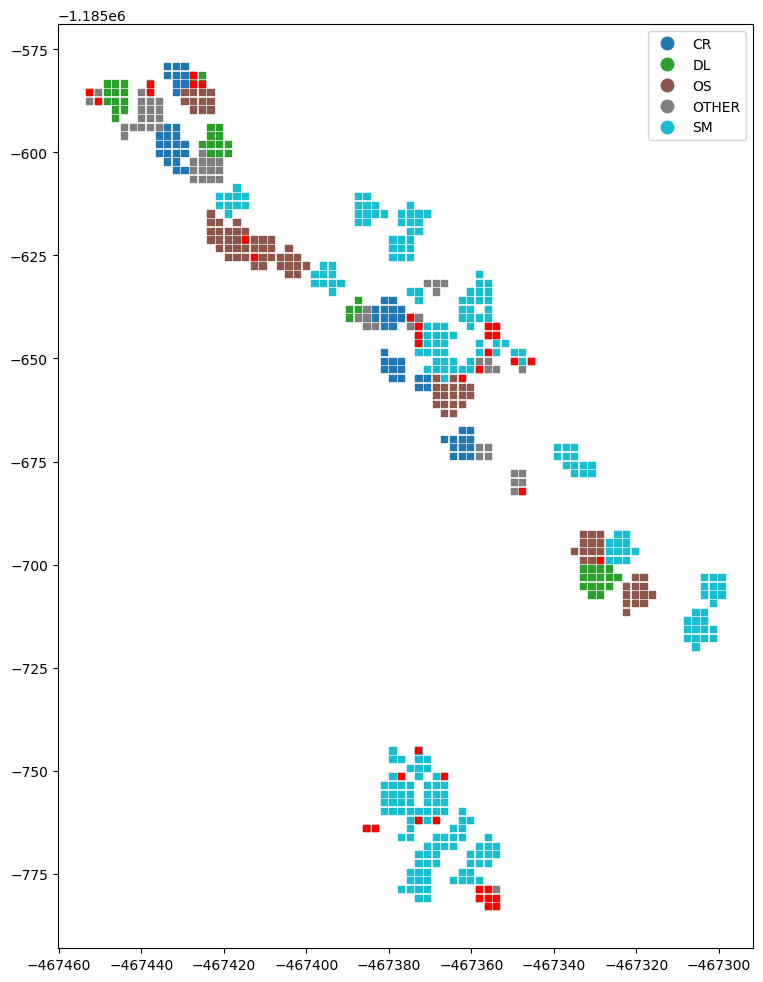

In [479]:
import wandb

cfg['model_name'] = 'conv1D_top4'
cfg['data_dir'] = os.path.join('..', 'data', 'Sverepec_spolu_preprocessed_top4')

# download model
api = wandb.Api()
model_artifact = api.artifact('hysped/hysped-conv1D_top4/run_rdtfm1l1_model:v14', type='model')
model_path = model_artifact.download()
model = tf.keras.models.load_model(model_artifact.file())
model.summary()

# load encoder
label_encoder = LabelEncoder()
encoder_filename = os.path.join(cfg['data_dir'], 'encoder-%s.npy' % cfg['class_column'])
label_encoder.classes_ = np.load(encoder_filename, allow_pickle=True)
num_classes = len(label_encoder.classes_)

# load data
gdf_X_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'X_val.parquet'))
gdf_Y_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'Y_val.parquet'))
gdf_val = pd.concat([gdf_X_val, gdf_Y_val[gdf_Y_val.columns[gdf_Y_val.columns != 'geometry']]], axis=1)

# class column must be of categorical type
class_column_enums = np.unique(gdf_val[cfg['class_column']].values)
class_column_dtype = pd.api.types.CategoricalDtype(class_column_enums)
gdf_val[cfg['class_column']] = gdf_val[cfg['class_column']].astype(class_column_dtype)

# plot validation data
gdf_val.plot(column=cfg['class_column'], legend=True, figsize=cfg['figsize'], marker=',', markersize=1)
plt.title('Y_val')
plt.show()

# rasterize validation data
def pairwise_min_diff(a: np.array):
    a = np.abs(a[:, None] - a)
    return a[a > 0].min()

factor = 10
xmin = pairwise_min_diff(gdf_val.geometry.x.unique())
ymin = pairwise_min_diff(gdf_val.geometry.y.unique())
resolution = (-xmin*factor,ymin*factor)
geo_grid = rasterize(
    gdf_val,
    class_column_enums,
    resolution=resolution,
    method='cubic'
)
geo_grid.get(cfg['class_column']).plot(figsize=cfg['figsize'])
plt.title('Y_val - rasterized\n1 pixel = %.2fm, %dx data downscaling' % (resolution[1], factor))
plt.show()

# X
gdf_val = geo_grid_to_gdf(geo_grid)
# map2other = [class_ for class_ in gdf_val[cfg['class_column']].unique() if class_ not in ['CR', 'DL', 'OS', 'SM']]
# gdf_val = gdf_val.replace({cfg['class_column']: {
#     class_: 'OTHER' for class_ in map2other
# }})
X_val = gdf_val[gdf_val.columns[~gdf_val.columns.isin(['geometry', cfg['class_column']])]]

# Y
Y_val = gdf_val[[cfg['class_column']]]
Y_val = label_encoder.transform(Y_val.values[:,0])
Y_val = to_categorical(Y_val)

# predict
Y_pred = predict_model(model, X_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

# evaluate
eval_results = model.evaluate(X_val, Y_val, return_dict=True)
metric_name = 'categorical_accuracy'

# draw plots
fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\ndata: %s/X_val,Y_val\n%s: %.2f%%\n' % (
    cfg['model_name'],
    model_artifact.name,
    os.path.basename(cfg['data_dir']),
    metric_name,
    float(eval_results[metric_name]) * 100.0)
)
plt.tight_layout()
plt.savefig(os.path.join(cfg['data_dir'], 'cm-%s.pdf' % model_artifact.name), format='pdf')
plt.show()

gdf_val['Y_pred'] = Y_pred.values
gdf_val['hit'] = gdf_val[cfg['class_column']] == gdf_val['Y_pred']
gdf_val[~gdf_val['hit']]

ax = gdf_val.plot(
    column=cfg['class_column'],
    legend=True,
    figsize=cfg['figsize'],
    marker=',',
    markersize=20
)
ax = gdf_val[~gdf_val['hit']].plot(
    ax=ax,
    legend=True,
    marker=',',
    markersize=20,
    color='red'
)
plt.show()

## Prediction on original data

In [534]:
def generate_noise_from_bands_stds(X: np.array, p: float = 0.1, mu: float = 0.0):
    i=0
    stds = p * np.std(X, axis=0)
    noise = np.zeros(shape=X.shape)
    for sigma in stds:
        noise[:,[i]] = np.random.normal(mu, sigma, (X.shape[0], 1))
        i+=1
    return noise

136/136 [==============================] - 1s 9ms/step - loss: 0.8579 - categorical_accuracy: 0.7700


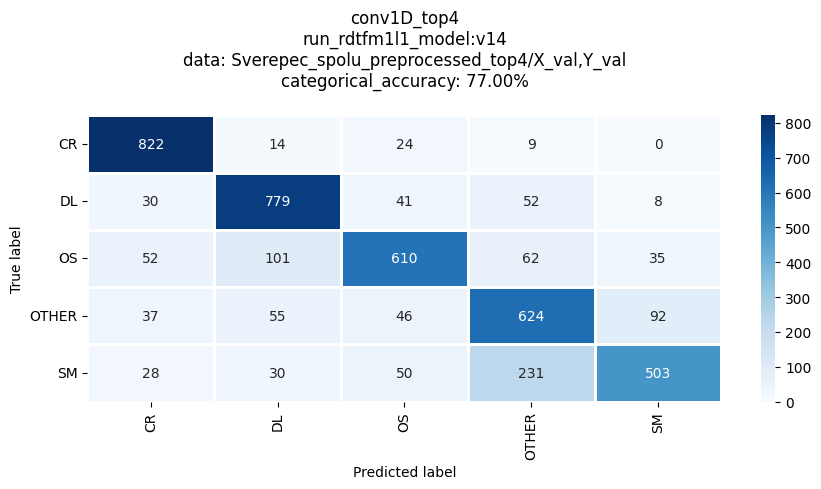

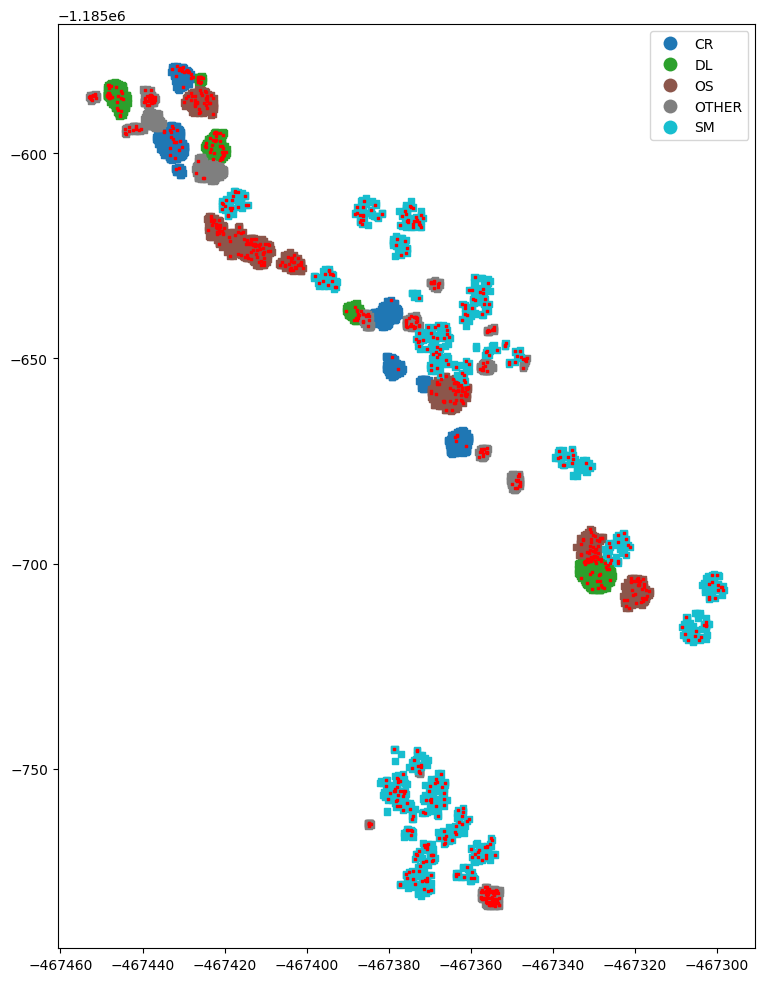

In [537]:
# load data
gdf_X_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'X_val.parquet'))
X_val = gdf_X_val.values[:,1:]
X_val = X_val.astype(np.float32)

# stress the model by adding noise
noise = generate_noise_from_bands_stds(X_val, 0.1)
X_val = X_val + noise

gdf_Y_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'Y_val.parquet'))
Y_val = to_categorical(
    label_encoder.transform(gdf_Y_val[cfg['class_column']]),
    num_classes=num_classes
)
Y_val = Y_val.astype(np.float32)

# predict
Y_pred = predict_model(model, X_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

# eval
eval_results = model.evaluate(X_val, Y_val, return_dict=True)
metric_name = 'categorical_accuracy'

# plot
fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\ndata: %s/X_val,Y_val\n%s: %.2f%%\n' % (
    cfg['model_name'],
    model_artifact.name,
    os.path.basename(cfg['data_dir']),
    metric_name,
    float(eval_results[metric_name]) * 100.0)
)
plt.tight_layout()
plt.savefig(os.path.join(cfg['data_dir'], 'cm-%s.pdf' % model_artifact.name), format='pdf')
plt.show()

gdf_Y_val['Y_pred'] = Y_pred.values
gdf_Y_val['hit'] = gdf_Y_val[cfg['class_column']] == gdf_Y_val['Y_pred']
gdf_Y_val[~gdf_Y_val['hit']]

ax = gdf_Y_val.plot(
    column=cfg['class_column'],
    legend=True,
    figsize=cfg['figsize'],
    marker=',',
    markersize=20
)
ax = gdf_Y_val[~gdf_Y_val['hit']].plot(
    ax=ax,
    legend=True,
    marker=',',
    markersize=1,
    color='red'
)
plt.show()

## test, whether rasterized pixels can be found in the original data

todo: it seems, that the rasterization does not do any kind of averaging when downsampling pixel data - look at the rasterization options or add noise to data

(541, 190)
(4335, 188)
(541, 191)


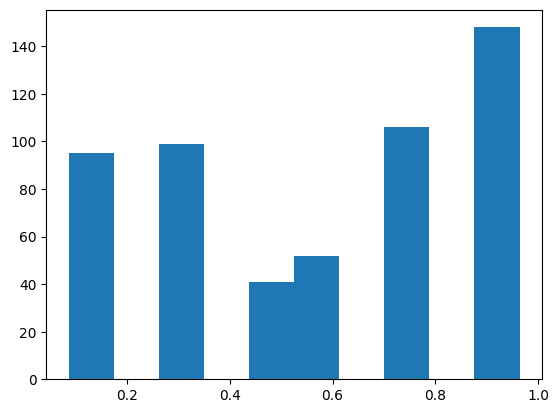

In [477]:
gdf_rasterized_test = gdf_val
print(gdf_rasterized_test.shape)

gdf_original_test = pd.concat(
    [
        gdf_X_val,
        gdf_Y_val.drop('geometry', axis=1) # remove geometry to be able to merge
    ],
    axis=1
)
print(gdf_original_test.shape)

df_merget = pd.merge(
    gdf_rasterized_test,
    gdf_original_test,
    on=gdf_original_test.columns[gdf_original_test.columns != 'geometry'].values.tolist(), # exclude geometry in joining
    how='inner'
)
print(df_merget.shape)

plt.hist(np.abs(df_merget.geometry_x.x - df_merget.geometry_y.x))
plt.show()